# Most common words and bigrams in the last minutes per location in Spain

**Author: Daniel Roncel Díaz**

**Date: 13/04/2021**

In [1]:
import codecs
import tweepy
import json
import time
import re # RegEx
import pandas as pd
import numpy as np
import os
from datetime import datetime
import emoji
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## 1. Load cities name

**Get the current path to access easily to input and output folders:**

In [2]:
folder_path = os.getcwd()

**Load all the Spain cities and its coordinates:**

In [3]:
cities_file = folder_path+'\input\spain_cities.csv'
df_cities = pd.read_csv(cities_file)

# cities_dict[city] = (latitude, longitude)
cities_dict = dict()
for idx, row in df_cities.iterrows():
    cities_dict[row['town']] = (row['latitude'], row['longitude'])
    
# Show a few cities in the dictionary    
list(cities_dict.keys())[:5]

['Abla', 'Abrucena', 'Adra', 'Albánchez', 'Alboloduy']

In [4]:
def location_filter(location, cities_dict, valid_end):
    """
    Returns the city the location parameter is associated to.
    If the city cannot be identified, returns and empty string.
    
    Arguments:
        location:
            string associated with the city that it is requested to find
        cities_dict:
            dictionary whose keys are the valid possible cities
        valid_end:
            set of possible valid suffixes (ignoring punctuation marks)
    """
    if location in cities_dict:
        coord = cities_dict[location]
        return location
    else:
        # Split location by any character not included below
        # Ensure that the accents are preserved when working with Spanish texts
        location_split  = re.split(r'[^A-ZÁÀÉÈÍÌÏÓÒÚÜa-záàéèíìïóòúùü0-9]+', location)

        # Remove all empty strings
        location_split = [location_split[i] for i in range(len(location_split)) if location_split[i] != '']
        
        if len(location_split) <= 1:
            return ''
        elif location_split[0] in cities_dict:
            if location_split[-1] in valid_end or location_split[-1] in cities_dict:
                coord = cities_dict[location_split[0]]
                return location_split[0]
            else:
                return ''
    return ''

**Load all the valid ends of a user location:**

In [5]:
valid_end = set()

file_name = folder_path+"/input/valid_ends.txt"
f = codecs.open(file_name, 'r', encoding='utf8')

city = f.readline()
while city != 'END':
    valid_end.add(city[:-2])
    city = f.readline()
f.close()

valid_end

{'Andalucía',
 'Aragón',
 'Asturias',
 'Canarias',
 'Cantabria',
 'Castilla y León',
 'Castilla-La Mancha ',
 'Catalunya',
 'Cataluña',
 'Ceuta',
 'Comunidad Valenciana',
 'Comunidad de Madrid',
 'Comunitat Valenciana',
 'España',
 'Euskadi',
 'Extremadura',
 'Galicia',
 'Galiza',
 'Islas Baleares',
 'Islas Canarias',
 'La Rioja',
 'Melilla',
 'Navarra',
 'País Vasco',
 'Principado de Asturias',
 'Región de Murcia',
 'Spain'}

In [6]:
# Test
location = "Madrid, Spain"
location_filter(location, cities_dict, valid_end)

'Madrid'

## 2. Set up our crawler

In [7]:
class Listener(tweepy.streaming.StreamListener):
    """
    Twitter crawler for tweet streaming.
    """
    def __init__(self, cities_dict, valid_end, cities_filter_function, max_minutes, \
                                             json_tweets_file, max_tweets=None, api=None):
        """
        Arguments:
            cities_dict:
                dictionary whose keys are the valid cities
                from which we can get tweets.
            valid_end:
                set of possible valid suffixes (ignoring punctuation marks).
            cities_filter_function:
                returns the city the location parameter is associated to. 
                If the location cannot be processed or it is not valid, 
                returns an empty string.
            max_minutes:
                maximum number of minutes streaming tweets.
            max_tweets:
                maximum number of tweets to stream.
            json_tweets_file:
                file to store the streamed tweets.
            api:
                attribute of the parent class. It won't be used in this code.
        """
        super(tweepy.streaming.StreamListener, self).__init__()
        self.cities_dict = cities_dict
        self.valid_end = valid_end
        self.cities_filter_function = cities_filter_function
        self.num_tweets = 0 # Current read tweets
        self.max_tweets = max_tweets
        self.time_limit = time.time() + max_minutes*60
        self.json_tweets_file = json_tweets_file
        self.api = api
        
    def on_data(self, data):
        """
        Function called every time a tweet is streamed. If the user's location is valid
        and can be retrieved by self.cities_filter_function, stores the tweet with its city 
        in json format in self.json_tweets_file.
        
        """
        try:
            # Append the new tweet in the file, if location is retrived
            with open(self.json_tweets_file, 'a') as f:
                tweet_json = json.loads(data)
                location = tweet_json['user']['location']
                
                if location != None:
                    # Try to retrieve user's location
                    user_location = self.cities_filter_function(location, self.cities_dict, self.valid_end)
                    # If it could be retrieved
                    if user_location != '':
                        tweet_json['user_location'] = user_location
                        f.write(json.dumps(tweet_json) + "\n\n")
                        
                        # Print the retrieved location. Useful for testing cities_filter_function
                        print(location +" -> "+user_location)
                        
                        self.num_tweets += 1
                        # If we read enough tweets our streamed for enough time, stop the exection
                        if self.max_tweets != None and self.num_tweets >= self.max_tweets:
                            return False
                        if self.time_limit < time.time():
                            return False
                        return True
                return True
        # If an error occurs, stop the execution
        except Exception as e:
            print(type(e).__name__)
            return True
        
    def on_error(self, status):
        print('Error :', status)
        return False

In [8]:
# Fill your twitter developer keys and secrets
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [9]:
# Set your keywords for the search
keywords = ["madrid"]
# New folder name: keyword1_keyword2_..._keywordN_DAY-MONTH-YEAR_HOUR.MINUTE.SECOND.jsonl
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H.%M.%S")
output_folder = folder_path+'/output/'+'_'.join(keywords)+'_'+dt_string
os.mkdir(output_folder)
# File name: keyword1_keyword2_..._keywordN.jsonl
# It will contain the tweets in json format
json_tweets_file = output_folder+'/'+'_'.join(keywords)+'.jsonl'

# Execution time
max_minutes = 5
twitter_stream = tweepy.streaming.Stream(auth, Listener(cities_dict=cities_dict, valid_end=valid_end, cities_filter_function=location_filter, max_minutes=max_minutes, json_tweets_file = json_tweets_file))
# Filter for the given keywords in Spanish tweets
twitter_stream.filter(track=keywords, languages=['es']) 

print('_______ End _______')

Madrid, Comunidad de Madrid -> Madrid
Madrid, Comunidad de Madrid -> Madrid
Torrelodones. Madrid -> Torrelodones
Madrid -> Madrid
Madrid -> Madrid
Madrid -> Madrid
Barcelona y Sitges -> Barcelona
Valencia (Spain) -> Valencia
Madrid -> Madrid
Madrid -> Madrid
Valencia, Spain -> Valencia
Murcia, Región de Murcia -> Murcia
Madrid, forever Madrid.. -> Madrid
Córdoba -> Córdoba
Madrid, Comunidad de Madrid -> Madrid
Badajoz -> Badajoz
Valencia -> Valencia
San Bartolomé de Tirajana -> San Bartolomé de Tirajana
Madrid -> Madrid
Madrid, Comunidad de Madrid -> Madrid
Madrid, Comunidad de Madrid -> Madrid
Badajoz -> Badajoz
Córdoba -> Córdoba
Madrid -> Madrid
Madrid -> Madrid
San Bartolomé de Tirajana -> San Bartolomé de Tirajana
Salamanca -> Salamanca
Madrid -> Madrid
Cádiz-Tenerife-Cádiz-Madrid -> Cádiz
Madrid -> Madrid
Madrid, Comunidad de Madrid -> Madrid
Madrid -> Madrid
Córdoba, Andalucía -> Córdoba
Madrid -> Madrid
Madrid, Comunidad de Madrid -> Madrid
Cádiz-Tenerife-Cádiz-Madrid -> Cádiz


## 3. Process the stored data

**Load the stored tweets in a pandas Dataframe:**

In [10]:
df = pd.read_json(json_tweets_file, lines=True)
df.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,user_location
0,NaN,None,2021-04-13 18:14:17,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,0,0,False,{'created_at': 'Tue Apr 13 15:25:00 +0000 2021...,"<a href=""http://twitter.com/download/android"" ...",RT @_MADtime: El @TeatroLara acoge 'Solitarias...,2021-04-13 18:14:17.505,False,"{'id': 313545233, 'id_str': '313545233', 'name...",Madrid
1,NaN,None,2021-04-13 18:14:18,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,0,0,False,{'created_at': 'Tue Apr 13 18:11:29 +0000 2021...,"<a href=""http://twitter.com/download/iphone"" r...","RT @Espacio_Pub: Llamamiento para ""conseguir q...",2021-04-13 18:14:18.161,False,"{'id': 304915745, 'id_str': '304915745', 'name...",Madrid
2,NaN,None,2021-04-13 18:14:19,"[50, 140]","{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,{'full_text': '@LeoooDC @gabriel_deck @RMBalon...,0,False,low,...,0,0,False,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",@LeoooDC @gabriel_deck @RMBaloncesto @teamtort...,2021-04-13 18:14:19.136,True,"{'id': 1765333609, 'id_str': '1765333609', 'na...",Torrelodones
3,NaN,None,2021-04-13 18:14:20,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,0,0,False,{'created_at': 'Mon Apr 12 18:41:45 +0000 2021...,"<a href=""https://about.twitter.com/products/tw...",RT @rafaruizmad: Este es el nuevo modelo de pl...,2021-04-13 18:14:20.630,False,"{'id': 16718844, 'id_str': '16718844', 'name':...",Madrid
4,NaN,None,2021-04-13 18:14:21,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,0,0,False,{'created_at': 'Tue Apr 13 18:12:19 +0000 2021...,"<a href=""http://twitter.com/download/android"" ...",RT @jopela2: El pueblo madrileño ha soportado ...,2021-04-13 18:14:21.303,False,"{'id': 4156102535, 'id_str': '4156102535', 'na...",Madrid


### 3.1 Normalize the tweets

In [11]:
def normalize(text):
    """
    Remove all the emojis, accents, undesired characters
    in a string and convert it to lowercase.
    
    Arguments:
        text:
            string to normalize.
    """
    # Delete emojis
    text = re.sub(emoji.get_emoji_regexp(), r' ', text)
    # Delete accents. With this approach we can keep the 'ñ' char, common in Spanish
    text = text.lower()
    original_char = 'ÁÀÉÈÍÌÏÓÒÚÙÜáàéèíìïóòúùü'
    new_char = 'AAEEIIIOOUUUaaeeiioouuu'
    
    for original, new in zip(original_char, new_char):
        text = text.replace(original, new)
    
    # Delete all the chars not included below. Transform it to lowercase
    text = re.sub(r'[^A-ZÑa-zñ0-9_ ]+', ' ', text).lower()
    
    return text

**See some of the original tweets to compare them with the normalized ones:**

In [12]:
df['text'].head()

0    RT @_MADtime: El @TeatroLara acoge 'Solitarias...
1    RT @Espacio_Pub: Llamamiento para "conseguir q...
2    @LeoooDC @gabriel_deck @RMBaloncesto @teamtort...
3    RT @rafaruizmad: Este es el nuevo modelo de pl...
4    RT @jopela2: El pueblo madrileño ha soportado ...
Name: text, dtype: object

**Normalize the tweets:**

In [13]:
df['text_normalized'] = df['text'].apply(normalize)
df['text_normalized'].head()

0    rt  _madtime  el  teatrolara acoge  solitarias...
1    rt  espacio_pub  llamamiento para  conseguir q...
2     leooodc  gabriel_deck  rmbaloncesto  teamtort...
3    rt  rafaruizmad  este es el nuevo modelo de pl...
4    rt  jopela2  el pueblo madrileño ha soportado ...
Name: text_normalized, dtype: object

### 3.2 Compute the list of words of each tweet

In [14]:
def text_to_words(text, stopwords_set, min_size):
    """
    Return all the words in a string that aren't stopwords and
    that are at least as large as the specified size.
    
    Arguments:
        text:
            string whose words we are interested in.
        stopwords_set:
            set of stopwords.
        min_size:
            minimum size of a word to be returned.
    """
    words = text.split()
    words = [word for word in words if word != '' and len(word) >= MIN_SIZE and word not in stopwords_set]
    return words

In [15]:
# Stopwords are the words that we want to delete from all tweets
STOPWORDS = set(stopwords.words('spanish') + ["rt", "http", "https", "co", "com", "es"])
# Minimum size of a word to be stored
MIN_SIZE = 2

df['text_words'] = df['text_normalized'].apply(lambda text: text_to_words(text, STOPWORDS, MIN_SIZE))
df['text_words'].head()

0    [_madtime, teatrolara, acoge, solitarias, estr...
1    [espacio_pub, llamamiento, conseguir, derecha,...
2    [leooodc, gabriel_deck, rmbaloncesto, teamtort...
3    [rafaruizmad, nuevo, modelo, plaza, ayto, madr...
4    [jopela2, pueblo, madrileño, soportado, pesima...
Name: text_words, dtype: object

### 3.2 Compute the list of bigrams of each tweet

In [16]:
df['text_bigrams'] = df['text_words'].apply(lambda text: list(ngrams(text,2)))
df['text_bigrams'].head()

0    [(_madtime, teatrolara), (teatrolara, acoge), ...
1    [(espacio_pub, llamamiento), (llamamiento, con...
2    [(leooodc, gabriel_deck), (gabriel_deck, rmbal...
3    [(rafaruizmad, nuevo), (nuevo, modelo), (model...
4    [(jopela2, pueblo), (pueblo, madrileño), (madr...
Name: text_bigrams, dtype: object

### 3.3 Compute the top used words per location

In [17]:
df_wb = df[['text_words', 'text_bigrams', 'user_location']]
df_wb = df_wb.groupby('user_location').sum()
df_wb.head()

,text_words,text_bigrams
user_location,,
Albacete,"[publico_es, datos, desmienten, ayuso, madrid,...","[(publico_es, datos), (datos, desmienten), (de..."
Almería,"[luciaguerras, humor, boomer, traido, consecue...","[(luciaguerras, humor), (humor, boomer), (boom..."
Arganda del Rey,"[raquelggc, rosaura, cambia, coche, gps, o9pq5...","[(raquelggc, rosaura), (rosaura, cambia), (cam..."
Badajoz,"[vox_es, vox, españoles, volveran, ser, ultimo...","[(vox_es, vox), (vox, españoles), (españoles, ..."
Barcelona,"[eduardoinda, sanchez, confirma, hachazo, fisc...","[(eduardoinda, sanchez), (sanchez, confirma), ..."


In [18]:
# Number of words to be shown per city
TOP = 5
# Compute the TOP words more used per city
df_wb['top_words'] = df_wb['text_words'].apply(lambda words: Counter(words).most_common(TOP))
df_wb['top_words'].head()

user_location
Albacete           [(publico_es, 1), (datos, 1), (desmienten, 1),...
Almería            [(luciaguerras, 1), (humor, 1), (boomer, 1), (...
Arganda del Rey    [(raquelggc, 1), (rosaura, 1), (cambia, 1), (c...
Badajoz            [(madrid, 3), (vox_es, 2), (vox, 2), (españole...
Barcelona          [(madrid, 8), (eugenio, 2), (martinez, 2), (br...
Name: top_words, dtype: object

### 3.4 Compute the top used bigrams per location

In [19]:
TOP = 5
df_wb['text_bigrams'] = df_wb['text_bigrams'].apply(lambda bigrams: Counter(bigrams).most_common(TOP))
df_wb['text_bigrams'].head()

user_location
Albacete           [((publico_es, datos), 1), ((datos, desmienten...
Almería            [((luciaguerras, humor), 1), ((humor, boomer),...
Arganda del Rey    [((raquelggc, rosaura), 1), ((rosaura, cambia)...
Badajoz            [((vox_es, vox), 2), ((vox, españoles), 1), ((...
Barcelona          [((eugenio, martinez), 2), ((martinez, bravo),...
Name: text_bigrams, dtype: object

### 3.5 Compute general stats

#### 3.5.1 Counter of tweets per city

In [20]:
users_per_location = df['user_location'].value_counts()
users_per_location.head()

Madrid       77
Barcelona    12
Valencia      7
Córdoba       7
Sevilla       3
Name: user_location, dtype: int64

#### 3.5.2 Top used words without regarding the location

In [21]:
words_freq = dict()

for location, row in df_wb.iterrows():
    for word, ctr in row['top_words']:
        if word not in words_freq:
            words_freq[word] = ctr
        else:
            words_freq[word] += ctr

In [22]:
TOP = 10
words_freq = Counter(words_freq).most_common(TOP)
print(words_freq)

[('madrid', 80), ('mas', 19), ('ayuso', 14), ('ifema', 13), ('real', 11), ('elchiringuitotv', 4), ('exclusinda', 4), ('inda', 4), ('cambia', 2), ('vox_es', 2)]


#### 3.5.3 Top used bigrams without regarding the location

In [23]:
bigrams_freq = dict()

for location, row in df_wb.iterrows():
    for bigrams, ctr in row['text_bigrams']:
        if bigrams not in bigrams_freq:
            bigrams_freq[bigrams] = ctr
        else:
            bigrams_freq[bigrams] += ctr

In [24]:
TOP = 10
bigrams_freq = Counter(bigrams_freq).most_common(TOP)
print(bigrams_freq)

[(('real', 'madrid'), 10), (('elchiringuitotv', 'exclusinda'), 4), (('exclusinda', 'inda'), 4), (('comunidad', 'madrid'), 4), (('idiazayuso', 'solo'), 4), (('solo', 'vamos'), 4), (('vamos', 'subir'), 4), (('inda', 'real'), 3), (('ayuso', 'madrid'), 2), (('vox_es', 'vox'), 2)]


## 4. Sentiment Analysis

**4.1 Perform sentiment analysis**

In [30]:
def get_sentiment(text, to_lang):
    sentiment = np.NaN
    try:
        sentiment = TextBlob(text).translate(to=to_lang).sentiment
    except:
        pass
    return sentiment

In [31]:
#Translate to English each tweet, then compute it's sentiment statistic estimations
df['sentiment'] = df['text_normalized'].apply(lambda text: get_sentiment(text, 'en'))
#Discard tweets that couldn't be translated to English
df = df.dropna(subset=['sentiment'])
df['polarity'] = df['sentiment'].apply(lambda sentiment: sentiment.polarity)
df['subjectivity'] = df['sentiment'].apply(lambda sentiment: sentiment.subjectivity)

In [32]:
#Scale polarity from [-1, 1] to [0, 1]
df['polarity'] = (df['polarity'] + 1) / 2

In [33]:
#Compute mean polarity and subjectivity per location
df_per_city = df[['user_location', 'polarity', 'subjectivity']].groupby(by='user_location').mean()
df_per_city.reset_index(inplace=True)
df_per_city.head()

,user_location,polarity,subjectivity
0,Albacete,0.633333,0.500000
1,Almería,0.150000,0.800000
2,Arganda del Rey,0.500000,0.000000
3,Badajoz,0.500000,0.016667
4,Barcelona,0.514732,0.142659


In [34]:
#Compute the number of tweets per location
location_ctr = df['user_location'].value_counts()
location_ctr = location_ctr.reset_index().rename(columns={'index': 'location', 'user_location': 'counter'})
location_ctr.head()

,location,counter
0,Madrid,76
1,Barcelona,12
2,Valencia,7
3,Córdoba,7
4,Sevilla,3


In [35]:
#Inner join to merge sentiment results and number of tweets per location
pd_map = pd.merge(left=df_per_city, right=location_ctr, left_on='user_location', right_on='location')
#Inner join to add the coordinates of each location
pd_map = pd.merge(left=pd_map, right=df_cities, left_on='user_location', right_on='town')
#Remove repeated attributes
pd_map = pd_map.drop(columns=['location', 'town'])

pd_map.head()

,user_location,polarity,subjectivity,counter,latitude,longitude
0,Albacete,0.633333,0.500000,1,38.99765,-1.860070
1,Almería,0.150000,0.800000,1,36.84016,-2.467922
2,Arganda del Rey,0.500000,0.000000,1,40.30095,-3.438080
3,Badajoz,0.500000,0.016667,2,38.87860,-6.970284
4,Barcelona,0.514732,0.142659,12,41.38792,2.169919


**4.2 Plot the results**

In [38]:
def get_radius(ctr, total):
    """
    Given the number of tweets in a location and the total number of
    tweets, return the radio of corresponding circle in the plot.
    
    Arguments:
        ctr:
            Number of tweets in the location
        total:
            Total number of tweets
    """
    
    if ctr < total*0.05:
        return 0.15
    elif ctr < total*0.1:
        return 0.2
    else:
        return 0.25

**4.2.1 Polarity plot**

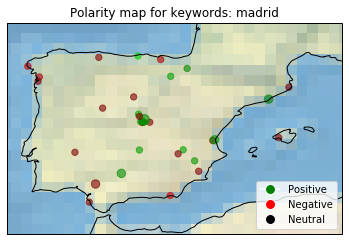

In [39]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_title('Polarity map for keywords: ' + ','.join(keywords))                                                                                               
ax.coastlines(resolution='50m')
ax.set_global()
ax.set_extent([-10.167, 5.633, 35.033, 45])

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Positive',
                          markerfacecolor='g', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Negative',
                          markerfacecolor='r', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Neutral',
                          markerfacecolor='black', markersize=10)]
ax.legend(handles=legend_elements, loc='lower right')
    
#Total number of tweets
total = pd_map['counter'].values.sum()
#Iterate over each location
for idx, row in pd_map.iterrows():
    xy = [row['longitude'], row['latitude']]
    radius = get_radius(row['counter'], total)
    color = None
    if row['polarity'] > 0.5:
        color = (0, row['polarity'], 0, 0.6) #Green color for positive tweets
    else:
        color = (1 - row['polarity'], 0, 0, 0.6) #Red color for negative tweets
    ax.add_patch(Circle(xy=xy, radius=radius, color=color))
#If the polarity level is low, i.e around 0.5 after normalization, it will be plot darker
    
#Save the image
try:
    os.mkdir(output_folder+'/images')
except:
    pass
plt.savefig(output_folder+'/images/polarity.png')

#Show the image
plt.show()

**4.2.2 Subjectivity plot**

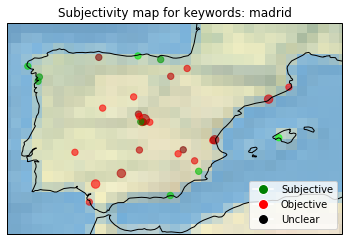

In [40]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_title('Subjectivity map for keywords: ' + ','.join(keywords))                                                                                              
ax.coastlines(resolution='50m')
ax.set_global()
ax.set_extent([-10.167, 5.633, 35.033, 45])

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Subjective',
                          markerfacecolor='g', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Objective',
                          markerfacecolor='r', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Unclear',
                          markerfacecolor='black', markersize=10)]
ax.legend(handles=legend_elements, loc='lower right')

#Total number of tweets
total = pd_map['counter'].values.sum()
#Iterate over each location
for idx, row in pd_map.iterrows():
    xy = [row['longitude'], row['latitude']]
    radius = get_radius(row['counter'], total)
    color = None
    if row['subjectivity'] > 0.5:
        color = (0, row['subjectivity'], 0, 0.6) #Green color por high subjectivity
    else:
        color = (1 - row['subjectivity'], 0, 0, 0.6) #Red color por high objectivity
    ax.add_patch(Circle(xy=xy, radius=radius, color=color))
#If the subjectivity level is not high enough, i.e around 0, it will be plot darker

#Save the image
try:
    os.mkdir(output_folder+'/images')
except:
    pass
plt.savefig(output_folder+'/images/subjectivity.png')

#Show the image
plt.show()

## 5 Save the results in files

**Store the top words used per location:**

In [41]:
words_file = output_folder+'/words_location.txt'

with open(words_file, 'w') as f:
    for location, row in df_wb.iterrows():
        f.write(location+'\n')
        
        for word, ctr in row['top_words']:
            f.write(word+' '+str(ctr)+'\n')
        f.write('\n')

**Store the top bigrams used per location:**

In [42]:
bigrams_file = output_folder+'/bigrams_location.txt'

with open(bigrams_file, 'w') as f:
    for location, row in df_wb.iterrows():
        f.write(location +'\n')
        
        for bigram, ctr in row['text_bigrams']:
            f.write(bigram[0]+' '+bigram[1]+' '+str(ctr)+'\n')
        f.write('\n')

**Store the number of tweets per location:**

In [43]:
main_file = output_folder+'/counter_location.txt'

with open(main_file, 'w') as f:
    for location in users_per_location.index:
        f.write(location+' '+str(users_per_location[location])+'\n')

**Store mean polarity and subjectivity of tweets per location:**

In [44]:
sentiment_file = output_folder+'/sentiment_location.txt'

with open(sentiment_file, 'w') as f:
    for idx, row in pd_map.iterrows():
        polarity = "%.3f" % row['polarity']
        subjectivity = "%.3f" % row['subjectivity']
        f.write(row['user_location']+' '+polarity+' '+subjectivity+'\n')

**Store the top used words without regarding the location:**

In [45]:
words_file = output_folder+'/words.txt'

with open(words_file, 'w') as f:
    for word, ctr in words_freq:
        f.write(word+' '+str(ctr)+'\n')

**Store the global top used bigrams without regarding the location:**

In [46]:
bigrams_file = output_folder+'/bigrams.txt'

with open(bigrams_file, 'w') as f:
    for bigram, ctr in bigrams_freq:
        f.write(bigram[0]+' '+bigram[1]+' '+str(ctr)+'\n')